In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split, cross_val_predict

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [17]:
# Load the dataset
df1 = pd.read_csv("../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv")
df2 = pd.read_csv("../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv")

In [18]:
df = pd.concat([df1, df2],ignore_index=True)

In [19]:
# Preprocessing the dataset
df.drop(['id', 'proto', 'service', 'state'], axis=1, inplace=True)
df['attack_cat'] = df['attack_cat'].replace(['Fuzzers', 'Analysis', 'Backdoor', 'DoS', 'Exploits', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 'Attack')
df['attack_cat'] = df['attack_cat'].replace(['Normal'], 'Normal')
df = pd.get_dummies(df, columns=['attack_cat'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   spkts              257673 non-null  int64  
 2   dpkts              257673 non-null  int64  
 3   sbytes             257673 non-null  int64  
 4   dbytes             257673 non-null  int64  
 5   rate               257673 non-null  float64
 6   sttl               257673 non-null  int64  
 7   dttl               257673 non-null  int64  
 8   sload              257673 non-null  float64
 9   dload              257673 non-null  float64
 10  sloss              257673 non-null  int64  
 11  dloss              257673 non-null  int64  
 12  sinpkt             257673 non-null  float64
 13  dinpkt             257673 non-null  float64
 14  sjit               257673 non-null  float64
 15  djit               257673 non-null  float64
 16  sw

In [21]:
df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat_Attack,attack_cat_Normal
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,...,2,0,0,0,1,2,0,0,0,1
1,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,...,2,0,0,0,1,2,0,0,0,1
2,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,...,3,0,0,0,1,3,0,0,0,1
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,...,3,0,0,0,2,3,0,0,0,1
4,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,...,3,0,0,0,2,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,24,0,0,0,24,24,0,1,1,0
257669,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,...,2,0,0,0,1,1,0,1,1,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,13,0,0,0,3,12,0,1,1,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,30,0,0,0,30,30,0,1,1,0


In [22]:
df.attack_cat_Attack.unique()

array([0, 1], dtype=uint8)

In [23]:
df.attack_cat_Normal.unique()

array([1, 0], dtype=uint8)

In [24]:
# Split the dataset into input features and target variable
X = df.drop(['label'], axis=1)

y = df['label']

In [61]:
X

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat_Attack,attack_cat_Normal
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,...,1,2,0,0,0,1,2,0,0,1
1,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,...,1,2,0,0,0,1,2,0,0,1
2,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,...,1,3,0,0,0,1,3,0,0,1
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,...,1,3,0,0,0,2,3,0,0,1
4,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,...,1,3,0,0,0,2,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,13,24,0,0,0,24,24,0,1,0
257669,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,...,1,2,0,0,0,1,1,0,1,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,3,13,0,0,0,3,12,0,1,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,14,30,0,0,0,30,30,0,1,0


In [43]:
def imbalance_ratio(y):
    n_samples = len(y)
    unique, counts = np.unique(y, return_counts=True)
    ir = [(n_samples - count) / n_samples for count in counts]
    fir = max(ir)
    return fir

# compute imbalance ratio
from collections import Counter
imbalance = imbalance_ratio(y)
print(f"Imbalance ratio max All classes: {imbalance_ratio(y):.10f}")

Imbalance ratio max All classes: 0.6390774354


In [44]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
def xgboost_objective( max_depth, learning_rate, subsample, colsample_bytree, gamma):
    params = {
        'objective': 'multi:softprob',
        'num_class': 5,
        'tree_method' : 'hist',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=False)
    val_score = model.best_score
    return -val_score

In [46]:
# Define the search space for the hyperparameters
pbounds = {
#    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 1)
}

In [47]:
# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgboost_objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.02631  | 0.6873    | 0.9507    | 0.3687    | 7.191     | 0.578     |
| 2         | -0.01551  | 0.578     | 0.05808   | 0.4344    | 7.208     | 0.854     |
| 3         | -0.02092  | 0.5103    | 0.9699    | 0.4179    | 4.486     | 0.5909    |
| 4         | -0.08353  | 0.5917    | 0.3042    | 0.2671    | 6.024     | 0.6456    |
| 5         | -0.2519   | 0.8059    | 0.1395    | 0.1532    | 5.565     | 0.728     |
| 6         | -0.07561  | 0.8926    | 0.1997    | 0.262     | 7.147     | 0.5232    |
| 7         | -0.9149   | 0.8038    | 0.1705    | 0.04188   | 9.642     | 0.9828    |
| 8         | -0.7448   | 0.9042    | 0.3046    | 0.05786   | 7.79      | 0.7201    |
| 9         | -1.115    | 0.561     | 0.4952    | 0.02685   | 9.365     | 0.6294    |
| 10        | -0.07329  | 0.8313    | 0.3117    | 0.26

In [48]:
# Train the XGBoost model using the best hyperparameters
best_xgb_params = {
    'objective': 'binary:logistic',
    'scale_pos_weight' : imbalance,
    'tree_method' : 'hist',
#    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'gamma': optimizer.max['params']['gamma']
}
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)
#best_model = xgb.train(best_xgb_params, dtrain, evals=[(dtest, 'validation', 'auc')], early_stopping_rounds=100, verbose_eval=True)
xgb_clf = xgb.XGBClassifier(**best_xgb_params)

# Train the XGBoost classifier on the training set
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["logloss","error", "auc"], eval_set=eval_set, verbose=True)


C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.31328	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.31328	validation_1-error:0.00000	validation_1-auc:1.00000
[1]	validation_0-logloss:0.17030	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.17030	validation_1-error:0.00000	validation_1-auc:1.00000
[2]	validation_0-logloss:0.09770	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.09770	validation_1-error:0.00000	validation_1-auc:1.00000
[3]	validation_0-logloss:0.05746	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.05746	validation_1-error:0.00000	validation_1-auc:1.00000
[4]	validation_0-logloss:0.03424	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.03424	validation_1-error:0.00000	validation_1-auc:1.00000
[5]	validation_0-logloss:0.02055	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.02055	validation_1-error:0.00000	validation_1-auc:1.00000
[6]	

[50]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.00000
[51]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.00000
[52]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.00000
[53]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.00000
[54]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.00000
[55]	validation_0-logloss:0.00001	validation_0-error:0.00000	validation_0-auc:1.00000	validation_1-logloss:0.00001	validation_1-error:0.00000	validation_1-auc:1.0000

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
xgb_clf.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'eval_metric': None,
 'gamma': 1.0,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 0.6390774353541117,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [52]:
# print Over and Under fitting the scores on training and test set

print('Training set score: {:.10f}'.format(xgb_clf.score(X_train, y_train)))

print('Test set score: {:.10f}'.format(xgb_clf.score(X_test, y_test)))

Training set score: 1.0000000000
Test set score: 1.0000000000


In [53]:
# make predictions on test data

y_pred = xgb_clf.predict(X_test)

In [56]:
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score
predictions_XGB = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
# evaluate predictions
accuracy_XGB = accuracy_score(y_test, y_pred)
print("Accuracy: %.10f%%" % (accuracy_XGB  * 100.0))
print("Accuracy: {:.10f}".format(accuracy_XGB))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535

Accuracy: 100.0000000000%
Accuracy: 1.0000000000


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

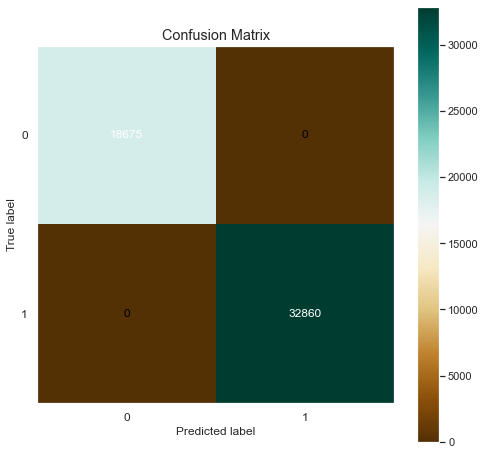

In [57]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(y_test, y_pred, cmap="BrBG")

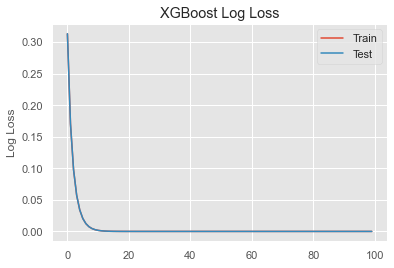

In [58]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

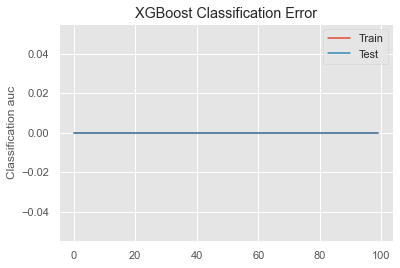

In [59]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification auc')
plt.title('XGBoost Classification Error')
plt.show()

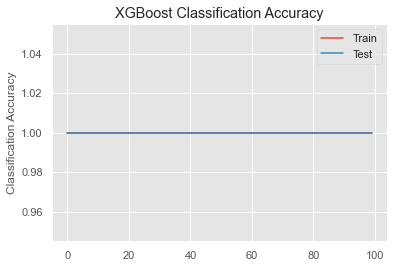

In [60]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.title('XGBoost Classification Accuracy')
plt.show()

## LSTM